# Classification with Logistic Regression

## A companion notebook implementing logistic regression from scratch in `python`

**Ingo Scholtes**  
*September 11th 2020*  

This tutorial accompanies a short lecture on classification with logistic regression. It showcases a simple machine learning workflow, including feature extraction, model fitting, and validation in a test data set. We implement a simple binary logistic regression classifier from scratch, including gradient ascent to perform a maximum likelihood estimation of the parameters. We further show how we can use the professional implementation of logistic regression in the popular machine learning package `sklearn`. 

We first need to import the following python packages:

In [2]:
%matplotlib inline

# The package numpy contains mathematical functions that we will need for our tutorial
import numpy as np

import seaborn as sns

# matplotplib allows us to generate plots in python. The parameter inline, which we set in the first line of this cell, ensures that matplotlib plots are properyl displayed within this jupyter notebook.
import matplotlib.pyplot as plt

# the mplot3d module of the matplotlib toolkits enables us to generate 3D plots
from mpl_toolkits.mplot3d import Axes3D

# we need the cm module since we want to use color maps to color matplotlib surface plots
from matplotlib import cm

# The machine learning package sklearn contains some exemplary data sets that we will use to test our implementation of 
# logistic regression. We specifically use the digits data set, which contains pixel images of hand-written digits.
from sklearn import datasets

# the pandas package simplifies the handling of panel data
import pandas as pd

# the special module of the package scipy contains an implementation of the logistic function
from scipy.special import expit

plt.style.use('default')
sns.set_style("whitegrid")

/Users/ingo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


To keep the code in the tutorial as simple as possible we further define some helper functions. To understand logistic regression, it is not neccessary to understand the technical details of those functions. In the comments below, we nevertheless briefly explain what each of those methods does:

In [3]:
# This function displays an 8x8 grayscale pixel image stored in a two-dimensional numpy array
def plotImage(img):
    font = {'color':  'red',
        'weight': 'bold',
        'size': 16,
        }    
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='none')    
    plt.xticks(range(8))
    plt.yticks(range(8))  
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()


# This function displays a rectangular grid with multiple pixel images showing different digit. 
# It colors a customizable fraction of the images according to the digit contained in the images
def plotDigitPanel(digits, indices, color_frac):
    for index, image in enumerate(digits.images[indices]):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), index+1)
        plt.axis('off')
        if index < int(color_frac * n):            
            alpha = 1.0
            if digits.target[indices[index]] == 5:
                plt.imshow(image, cmap=plt.cm.Blues, interpolation='nearest', alpha=alpha)
            elif digits.target[indices[index]] == 6:
                plt.imshow(image, cmap=plt.cm.Reds, interpolation='nearest', alpha=alpha)            
        else:
                plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', alpha=0.5)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.1, wspace = 0.1)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.show()


# This function plots features of images as defined in the lecture. A configurable fraction of those features 
# will be colored according to their respective classes. If highlight is not None, the feature with the given 
# index will be highlighted. 
def plotData(data, classes, color_frac=1.0, highlight=None, show_validation=True, file=None):
    h = 0.02    
    alpha = 0.7
    s = 60

    x_min, x_max = 0, 7

    if color_frac>0:
        y = range(n, 0, -1)
        y_min, y_max = 0, n+1
    else:
        y = range(n, 0, -1)
        y_min, y_max = 0, n+1

    colored = int(n*color_frac)
    if not highlight == None:
        plt.axhline(data[colored+highlight][1])
        plt.axvline(data[colored+highlight][0])
        plt.scatter(data[:, 0][:colored], [y[:colored]], c=classes[:colored], cmap = plt.cm.coolwarm, alpha=0.3, s=s, edgecolors='k')    
        plt.scatter(data[:, 0][colored:], y[colored:], s=s, edgecolors='k', c='black', alpha=0.3, marker='x')
        plt.scatter(data[:, 0][colored+x], y[colored+highlight], s=s, edgecolors='k', c='black', marker='x')
    else:
        plt.scatter(data[:, 0][:colored], y[:colored], c=classes[:colored], cmap = plt.cm.coolwarm, s=s, edgecolors='k', alpha=alpha)
        if show_validation:
            plt.scatter(data[:, 0][colored:], y[colored:], s=s, edgecolors='k', c='black', alpha=0.5, marker='x')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(r'feature $X$', fontsize=18)
    plt.ylabel(r'image', fontsize=18)
    plt.tick_params(axis='both', labelsize=14)
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
    frame1.axes.yaxis.set_ticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    frame1.axes.yaxis.grid()
    plt.show()

## Data Import and Feature Extraction

Our is to develop a classifier that can recognize hand-written digits contained in a set of 8x8 pixel images. The machine learning package `sklearn` contains an example data set, which we can use to illustrate this simple classification problem. We can load this data set as follows:

In [4]:
digits = datasets.load_digits()

Let's have a look at the structure of the data. The variable `digits` is a `dictionary`, which contains multiple entries. The entry `digits.DESCR` contains a detailed explanation of the data set:

In [5]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

For our tutorial, the dictionary entries `digits.images` and `digits.target` are particularly relevant. `digits.images` is a list of two-dimensional 8x8 arrays, which contain the pixel values of each image. The pixel values from 0 to 16 represent different grayscales, with 0 being white and 16 being black. We can, for instance, print the two-dimensional array of pixel values of the image with index 15:

In [6]:
print(digits.images[15])

[[ 0.  5. 12. 13. 16. 16.  2.  0.]
 [ 0. 11. 16. 15.  8.  4.  0.  0.]
 [ 0.  8. 14. 11.  1.  0.  0.  0.]
 [ 0.  8. 16. 16. 14.  0.  0.  0.]
 [ 0.  1.  6.  6. 16.  0.  0.  0.]
 [ 0.  0.  0.  5. 16.  3.  0.  0.]
 [ 0.  1.  5. 15. 13.  0.  0.  0.]
 [ 0.  4. 15. 16.  2.  0.  0.  0.]]


From the array displayed above, we can guess that this image shows a five. To check this, we can use the list `digits.target`, which contains the actual digit displayed in the image, i.e. the ground truth that we want to predict with our classifier.

In [7]:
print(digits.target[15])

5


To plot the gray scale image contained in the pixel array above, we can use the helper function `plotImage`. We simply pass the two-dimensional array of pixel values:

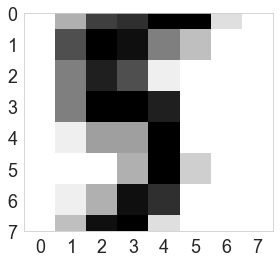

In [8]:
plotImage(digits.images[15])

We now know how we can access our test data and how we can display them. Let us now start with the actual classification, i.e. we are interested in a function which, for each image, predicts which digit is displayed in the image. We can then use the ground-truth digit stored in `digits.target` to validate our prediction.

Each of our images contains 64 gray-scale values, i.e. we can see our set of images as a set of points in a 64-dimensional space. Real images will have million pixels, which highlights the problem that we are typically confronted with high-dimensional data. A first step before applying machine learning technique is thus to reduce the dimensionality of our problem. This is important for multiple reasons: First, dealing with high dimensional data is computationally demanding. Second, there is the so-called *curse of dimensionality* which states that the number of points required in a high-dimensional feature space grows exponentially with the dimensionality of the space. Hence, even millions of images in a feature space that has millions of dimensions is a very sparse data set! This comes with a high risk of overfitting, so it is a good idea to  reduce the dimensionality of our problem in the first step. 

We call this process of mapping a high-dimensional data set to a feature space with smaller dimensions *dimensionality reduction* or *feature extraction*. In our case, we want to extract a small number of (ideally one) numerical features that capture patterns in our images that are relevant for the classification. We could think of many different approaches: counting the number of white pixels, the average brightness of pixels, the borders based on the contrast of pixels. etc. To simplify matters, we use a very simple and rather naive approach: We simply compute the weighted average pixel coordinate in the two dimensions, and then simply pick one of those dimensions. This allows us to embed our image with 64 pixel values into a one-dimensional feature space. The idea is that this average coordinate tells us how far up/down left/right the digit is, and we can use variations between the images that are due to the shape of the different digits displayed to perform the classification. 

The following function computes the two average coordinates in x- and y direction of our image, using the pixel value as a weight in the weighted average:

In [9]:
def imageTo2D(digit):
    m = np.reshape(digit, (8,8))
    mass = 0
    for i in range(8):
        for j in range(8):
            mass += m[i,j] * np.array([i,j])
    return mass/np.sum(m)

Let us apply this to our example image:

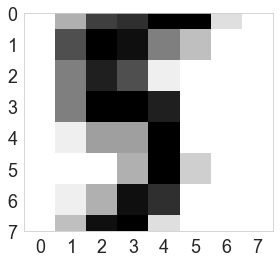

[2.97878788 2.93333333]


In [12]:
plotImage(digits.images[15])
d = imageTo2D(digits.images[15])
print(d)

We can compare this with the image displaying a **6**. 

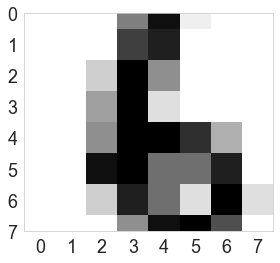

[4.16507937 3.89206349]


In [25]:
plotImage(digits.images[16])
d = imageTo2D(digits.images[16])
print(d)

The fact that the shape of this digit is different is captured in the difference in the weighted average of the coordinate. Our idea is now to utilize those variations to distinguish images showing a five from those showing a six. This yields a binary classification problem that we can address using logistic regression.

Let us first select 100 random images showing a five or a six. We then store the image data as well as ground truth classes in the variables `data` and `classes`.

In [27]:
n = 100

indices = np.where( (digits.target==5) | (digits.target==6))[0]
indices = np.random.choice(indices, n)

data = np.array([ imageTo2D(d) for d in digits.images[indices]])
classes = digits.target[indices]

We can now use our helper function `plotDigitPanel` to visually display our 100 images. We further color all images based on the ground truth classes, i.e. the digits displayed in the image. Those images showing a **5** are colored in blue, while those showing a six are colored in red. Note that this coloring is only for illustrative purposes, i.e. we do not change the pixels of the underlying data! 

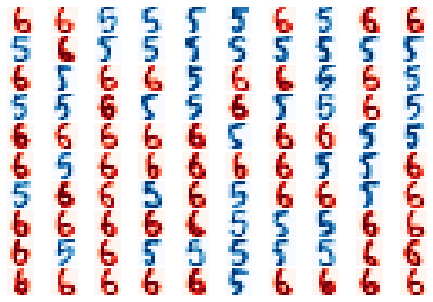

In [28]:
plotDigitPanel(digits, indices, 1)

To simplify some later tasks (like the use of logistic regression in `sklearn`), we additionally store our data in a `pandas` dataframe. Here we also introduce a new column `target` which assumes a value of 1 if the digit is six, and a zero if the digit is five. This highlights that we will be using the digit six as the positive class of our binary classification problem. We also store the average x, and y coordinates of the images (our two one-dimensional features) in two columns of the dataframe.

In [31]:
df = pd.DataFrame({'x': data[:,0], 'y': data[:,1], 'digit': classes, 'target': (classes==6).astype(int)})
df

,x,y,digit,target
0,4.328767,3.684932,6,1
1,4.324324,3.096525,6,1
2,3.272414,3.458621,5,0
3,3.376384,3.328413,5,0
4,2.871972,3.207612,5,0
...,...,...,...,...
95,3.206790,3.049383,5,0
96,4.237805,3.207317,6,1
97,4.242424,3.724242,6,1
98,4.293629,3.332410,6,1


We can now use the helper function `plot_data` to generate a scatter plot of the feature values. Here we will only use the x-dimension from above, which turns out to be sufficient for our classification. Every image thus corresponds to a point on the real line, and we will plot all of the points of the 100 images above, coloring each point according to the digit displayed in the corresponding image.

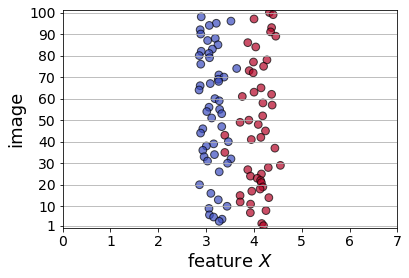

In [19]:
plotData(data, classes)

We see that the two classes of images have different average x coordinates, where the images showing a five tend to have a smaller average x-coordinate than those images showing a six. We can further illustrate this by a plot of the histograms of the coordinates of the two classes, with a kernel density estimate:

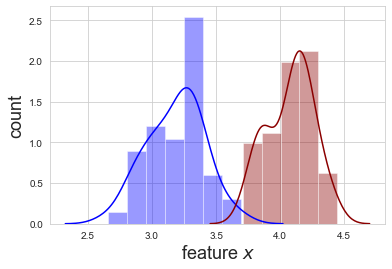

In [32]:
sns.distplot(df.query('digit==5')[['x']], color='blue')
sns.distplot(df.query('digit==6')[['x']], color='darkred')
plt.xlabel(r'feature $x$', fontsize=18);
plt.ylabel(r'count', fontsize=18);

## Supervised Statistical Classification

Now that we have embedded the 64 pixel values of our images into a one-dimensional feature space $\mathbb{F}=\mathbb{R}$ we can formally the classification problem. There are a number of different classification problems, which generally fall into two categories: **unsupervised** and **supervised classification**.

**Unsupervised** methods detect patterns in unlabeled data and allow to infer which of the images belong to the same class. In the example above, we could use clustering algorithms to detect that there are two different digits shown in the images, and we could infer which images are showing the same digits, even though we may not know what these digits actually are. Such unsupervised methods do not require labeled examples, because they are based on patterns in the distribution of features.


**Supervised** methods utilize labeled training data, in which we have access to the correct classes, i.e. a subset of the images for which we know which digit is being displayed. Our goal is to use such labeled examples to learn a classifier function, that can then be generalized to unseen examples. Examples include Support Vector Machines, Decision Trees, or logistic regression, which we explain in more detail below. 

In a nutstell, we will use a set of labeled training examples consisting both the features and the classes to learn a classifier function $C: \mathbb{R} \rightarrow \{5,6\}$. In the following, we will use 70 % of the data as training data, i.e. we use 30 of the 100 images to validate the classification. For simplicity, we use the first 70 images in our pandas data frame as training data, and the remaining 70 images as test data.

In [33]:
training_frac = 0.7
training_samples = int(training_frac*n)

df['train'] = df.index < training_frac*n
df

,x,y,digit,target,train
0,4.328767,3.684932,6,1,True
1,4.324324,3.096525,6,1,True
2,3.272414,3.458621,5,0,True
3,3.376384,3.328413,5,0,True
4,2.871972,3.207612,5,0,True
...,...,...,...,...,...
95,3.206790,3.049383,5,0,False
96,4.237805,3.207317,6,1,False
97,4.242424,3.724242,6,1,False
98,4.293629,3.332410,6,1,False


Let's use our helper function to color the first 70 images, which highlights which of the images are used to learn the classifier function, and which images are used as a test set:

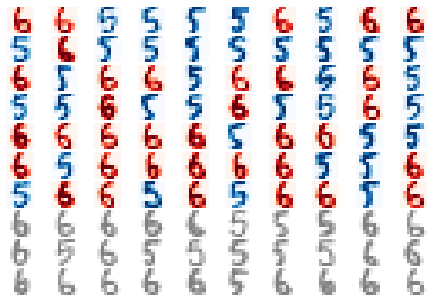

In [34]:
plotDigitPanel(digits, indices, training_frac)

We can further use the function `plotData` to show which data points in our feature space belong to the training set: 

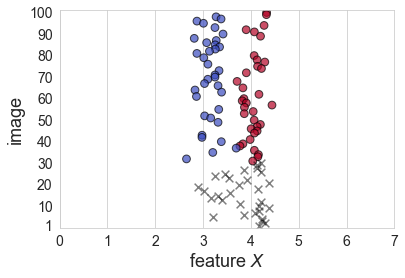

In [35]:
plotData(data, classes, color_frac=training_frac)

## Logistic Regression

Let us now explain the logistic regression classifier. First of all, logistic regression is a statistical classification technique, i.e. we are interested in a conditional probability $P(C=c|x)$ which for each point $x$ in the feature space assigns a probability that an image with this feature belongs to class $c$. 

In its most elementary form, logistic regression is a binary classification algorithm, which requires dichomotous classes such as {False, True}, {0, 1}, or {Negative, Positive}. In our case we will use the two classes {5, 6} where we treat the class 6 as the Positive class.

As explained in the lecture, starting from a linear model for the log-odds of the two classes, logistic regression uses the logistic function $\sigma$ to express the probability of the positive class as: 

$P(C=6|x) = \sigma(\beta_0 + \beta_1 x)$

where the intercept $\beta_0$ and the slope $\beta_1$ are the coefficients of a linear model. The following helper function plots a logistic model with given coefficients along with a set of training data points. Following our coding as positive/negative class, instances of class six are encoded as 1 while instances of class five are coded as zero: 

In [46]:
def plot_logistic_model(df, intercept, slope):
    plt.scatter(x=df.query('digit==5')[['x']], y=df.query('digit==5')['target'], alpha=0.5, color='blue', label='class 5',  s=60)
    plt.scatter(x=df.query('digit==6')[['x']], y=df.query('digit==6')['target'], alpha=0.5, color='darkred', label='class 6',  s=60)
    xx = np.linspace(1, 6, 50)
    plt.ylim(-0.1,1.1)
    plt.axhline(y=0.5, color='black')    
    frame1 = plt.gca()
    frame1.axes.set_yticks([0, 0.5, 1])

    boundary = -intercept/slope
    if slope>0:
        frame1.axes.fill_between(np.linspace(boundary, 7), 0, 1, alpha=0.2, facecolor='darkred')
        frame1.axes.fill_between(np.linspace(0, boundary), 0, 1, alpha=0.2, facecolor='blue')
    else:
        frame1.axes.fill_between(np.linspace(boundary, 7), 0, 1, alpha=0.2, facecolor='blue')
        frame1.axes.fill_between(np.linspace(0, boundary), 0, 1, alpha=0.2, facecolor='darkred')

    plt.plot(xx, intercept + slope*xx, c='green', lw=2, label=r'$\beta_0 + x \beta_1$')
    plt.plot(xx, expit(intercept + slope*xx), c='red', lw=2, label=r'$\sigma(\beta_0 + \beta_1 x)$')
    plt.legend()

Let us plot this for a specific set of parameters:

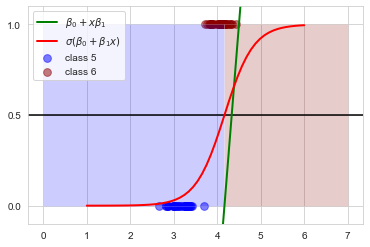

In [52]:
plot_logistic_model(df[df['train']==True], intercept = -12.5, slope = 3)

In the plot above, we have highlighted the decision boundary between class five (blue) and class six (red), which is at the point where the logistic model crosses the probability of 0.5 for class six. The model above is reasonable in so far as it assigns a higher probability of class six to those points in the feature space that are larger, which matches the pattern in our feature space. Let's see what happens if we invert the sign of the coefficients:

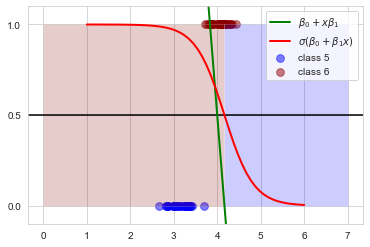

In [53]:
plot_logistic_model(df[df['train']==True], intercept = 12.5, slope = -3)

We have inverted the curve, and now the model assigns smaller probability of class six to larger values of x, which is exactly the opposite of the pattern in the feature space, so this is not a reasonable model. 

We can use likelihood estimation to assess the explanatory power or plausibility of a logistic model with a given value for the coefficients in our training data. In the lecture we have seen that we can easily compute this based on the classes and features in our training set. In the following, for reasons of numerical stability, we will calculate the log-likelihood, i.e. we have made a logarithmic transformation of the likelihood function given in the lecture. Since the logarithm is a monotonic transformation, this does not affect the maximum, i.e. it does not matter if we maximize the likelihood or the log-likelihood function:

In [54]:
def log_likelihood(intercept, slope, data):
    log_l = 0
    for index, row in data.iterrows():
        x_i = row['x']
        y_i = row['target']
        if y_i == 1: # we fit the probability for class 1
            log_l += np.log(expit(intercept+slope*x_i))
        else:
            log_l += np.log(1-expit(intercept+slope*x_i))
    return log_l

Let's now see whether we can use the likelihood function to assess the plausibility of the different coefficients above:

In [55]:
print(log_likelihood(intercept=12.5, slope=-3, data=df[df['train']==True]))

-128.32636808059826


For the parameters that capture the opposite of the pattern in our feature space, the log-likelihood is very small.  If we invert the sign of the coefficients, we should get a much more plausible model with a larger likelihood:

In [57]:
print(log_likelihood(intercept=-12.5, slope=3, data=df[df['train']==True]))

-33.63646641523374


Indeed, we get a value for the model likelihood that is more than 90 orders of magnitude larger! 

## Maximum Likelihood Estmation via Gradient Ascent

But how do we find the parameters that maximise the likelihood? In the lecture, I have mentioned that there is no simple analytical solution for the maximum likelihood estimate of the logistic regression model, but we can use the partial derivatives of the log-likelihood function to implement a gradient ascent algorithm. 

This algorithm effectively uses the smoothness of the likehood manifold in the parameter space of the logistic regression model, moving up the surface until a maximum is reached.

Let us first plot the likelihood manifold. Since we have two parameters, we get a surface in a three-dimensional space.

<Figure size 432x288 with 0 Axes>

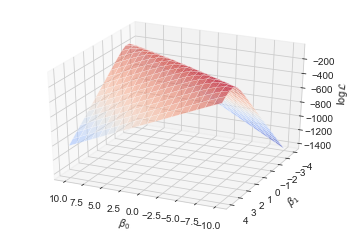

In [59]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

beta0_mesh = np.linspace(-10, 10, 20)
beta1_mesh = np.linspace(-4, 4, 20)
beta0_mesh, beta1_mesh = np.meshgrid(beta0_mesh, beta1_mesh)
ax.plot_surface(beta0_mesh, beta1_mesh, log_likelihood(beta0_mesh, beta1_mesh, df), cmap=cm.coolwarm, alpha=0.55, rstride=1, cstride=1, linewidth=0.2, shade=True)

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel(r'$\log\mathcal{L}$')
ax.view_init(30, 115)

Let us now implement the gradient ascend algorithm to estimate the optimal parameters heuristically. For this, we need the two partial derivatives of the log-likelihood function. They are easy to calculate for the log-transformed likelihood function as follows:

$\log \mathcal{L}(\beta_0, \beta_1)  = \sum_{i, c_i=6} \log P(C=6|x_i) + \sum_{i, c_i=5} \log \left(1-P(C=6|x_i))\right) = \sum_{i, c_i=6} \log \sigma (\beta_0 +\beta_1 x_i) + \sum_{i, c_i=5} \log \left(1-\sigma (\beta_0 +\beta_1 x_i)\right) $

The partial derivates of $\mathcal{L}(\beta_0, \beta_1)$ in the direction $\beta_0$ and $\beta_1$ can then be given as: 

$ \frac{\partial \log \mathcal{L}(\beta_0, \beta_1)}{\partial \beta_0} = \sum_i y_i - \sigma(\beta_0 + \beta_1 x_i)  $  
          $ \frac{\partial \log \mathcal{L}(\beta_0, \beta_1)}{\partial \beta_1} = \sum_i x_i \left[y_i - \sigma(\beta_0 + \beta_1 x_i)\right]$
          
where we define $y_i=1$ for all data points with $c_i=6$ and $y_i=0$ for all data points with $c_i=5$.

Let us implement those partial derivatives as functions, so we can use them in our gradient ascent algorithm:

In [60]:
def partial_beta_0(beta_0, beta_1, data):
    r = 0
    for index, row in data.iterrows():
        x_i = row['x']
        y_i = row['target']
        r += y_i - expit(beta_0+beta_1*x_i)
    return r

def partial_beta_1(beta_0, beta_1, data):
    r = 0
    for index, row in data.iterrows():
        x_i = row['x']
        y_i = row['target']
        r += x_i * (y_i - expit(beta_0+beta_1*x_i))
    return r

We can now use these partial derivatives to gradually move up the likelihood manifold, until we either reach a maximum, or the change of the iterative move is smaller than a given threshold. In each step, we move a distance of gamma along the partial derivatives at the current point in the parameter space and we perform a maximum of 1000 iterations before we stop.

In [61]:
def estimate_gradient_ascent(data, initial_params=(0,0), gamma = 0.01, tol = 1e-12, max_iter=1000):
    fitted_beta_0 = initial_params[0]
    fitted_beta_1 = initial_params[1]
    L = log_likelihood(fitted_beta_0, fitted_beta_1, data)

    path_beta_0 = []
    path_beta_1 = []
    path_loglikelihood = []

    for i in range(max_iter):
        path_beta_0.append(fitted_beta_0)
        path_beta_1.append(fitted_beta_1)        
        path_loglikelihood.append(L)

        last_beta_0 = fitted_beta_0
        last_beta_1 = fitted_beta_1
        last_L = L

        # move along the gradient for both parameters
        fitted_beta_0 = last_beta_0 + gamma * partial_beta_0(last_beta_0, last_beta_1, data)
        fitted_beta_1 = last_beta_1 + gamma * partial_beta_1(last_beta_0, last_beta_1, data)

        step_beta_0 = fitted_beta_0 - last_beta_0
        step_beta_1 = fitted_beta_1 - last_beta_1

        L = log_likelihood(fitted_beta_0, fitted_beta_1, data)

        if abs(step_beta_0) + abs(step_beta_1) <= tol:
            break
    return fitted_beta_0, fitted_beta_1, path_beta_0, path_beta_1, path_loglikelihood

Let us start at a point that we know has very small likelihood, i.e. a point where both the slope and the intercept are negative.

In [62]:
beta_0, beta_1, path_beta_0, path_beta_1, path_loglikelihood = estimate_gradient_ascent(df[df['train']==True], (-1, -1))

print(beta_0)
print(beta_1)

-16.87404463422563
4.696337271032865


Conveniently, the implementation of the gradient ascent algorithm above also returns the path in the likelihood landscape that the gradient ascent has taken. We can plot this path in the 3D plot from before, to visualize the optimization process:

<Figure size 432x288 with 0 Axes>

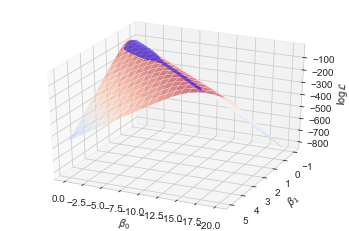

In [67]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

min_b0 = min(path_beta_0)
max_b0 = max(path_beta_0)
min_b1 = min(path_beta_1)
max_b1 = max(path_beta_1)
beta0_mesh = np.linspace(min(min_b0, -20), max(max_b0, 0), 20)
beta1_mesh = np.linspace(min(min_b1, 0), max(max_b1, 5), 20)
beta0_mesh, beta1_mesh = np.meshgrid(beta0_mesh, beta1_mesh)
ax.plot_surface(beta0_mesh, beta1_mesh, log_likelihood(beta0_mesh, beta1_mesh, df[df['train']==True]), cmap=cm.coolwarm, alpha=0.55, rstride=1, cstride=1, linewidth=0.2, shade=True)

#ax.scatter3D(path_beta_0, path_beta_1, path_loglikelihood, color='blue')
ax.plot3D(path_beta_0, path_beta_1, path_loglikelihood, color='blue', alpha=0.5, linewidth=3)

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel(r'$\log\mathcal{L}$')
ax.view_init(30, 115)

The resulting log-likelihood is much larger than the two points that we have tested above:

In [71]:
log_likelihood(beta_0, beta_1, df[df['train']==True])

-10.930023384905128

We can now plot the fitted logistic function as well as the fitted linear log-odds function. The decision boundary is given by the point at which the logistic model crosses 0.5, which coincides with the point at which the linear model of the log-odds function crosses zero.

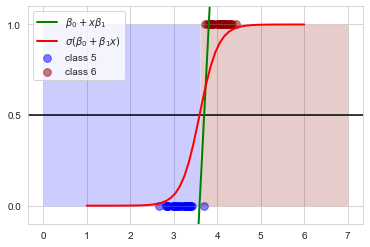

In [72]:
plot_logistic_model(df[df['train']==True], beta_0, beta_1)

For all data points right of that boundary we predict the digit six (class 1), while for all points left of that boundary we predict the digit five (class 0). We implement this in terms of a predict function and apply it to some example images:

In [74]:
def predict(beta_0, beta_1, x):
    if expit(beta_0 + x * beta_1)>0.5:
        return 6
    else:
        return 5

Our first example shows a five:

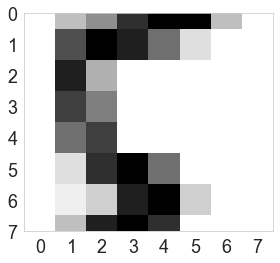

In [79]:
plotImage(digits.images[indices][45])

In [81]:
x, y = imageTo2D(digits.images[indices][45])
predict(beta_0, beta_1, x)

5

Our second example shows a six, so let us see whether we correctly classify this:

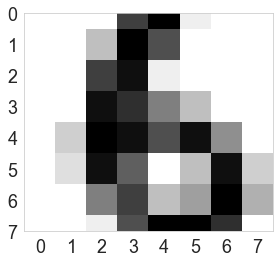

In [82]:
plotImage(digits.images[indices][46])

In [83]:
x, y = imageTo2D(digits.images[indices][46])
predict(beta_0, beta_1, x)

6

At least in those two examples, our classifier actually works. We can now test it a bit more systematically, by applying it to the 30 test images that we have not used to fit our logistic regression model. This gives us a first idea how well it generalizes to unseen data.

In [99]:
test_data = df[df['train']==False].copy()

xx = test_data['x']
test_data['predicted'] = [ predict(beta_0, beta_1, x) for x in xx]
test_data['error'] = test_data['predicted']!=test_data['digit']
test_data

,x,y,digit,target,train,predicted,error
70,4.217143,3.357143,6,1,False,6,False
71,4.129825,3.270175,6,1,False,6,False
72,4.119454,3.658703,6,1,False,6,False
73,3.862434,3.605820,6,1,False,6,False
74,4.202454,3.245399,6,1,False,6,False
75,3.469091,3.541818,5,0,False,5,False
76,3.254613,3.059041,5,0,False,5,False
77,3.533141,3.521614,5,0,False,5,False
78,3.927954,3.478386,6,1,False,6,False
79,4.379928,3.655914,6,1,False,6,False


In this particular example, our simple classifier correctly classifies all 30 test images. We can plot the classification visually, by coloring the predicted digits in red (predicted six) and blue (predicted five):

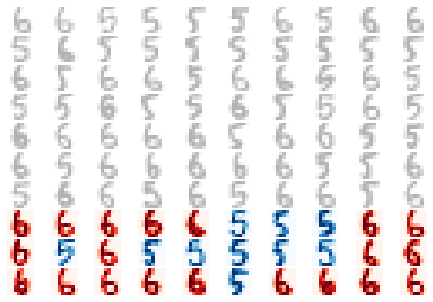

In [94]:
#%% plot predicted classes for validation set
training_samples = int(training_frac*n)
prediction = [predict(beta_0, beta_1, s[0]) for s in data[training_samples:]]

for index, image in enumerate(digits.images[indices]):
    plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), index+1)
    plt.axis('off')
    if index < int(training_frac * n):
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', alpha=0.3)
    else:
        x = int(training_frac*n)
        if prediction[index-x] == 5:
            plt.imshow(image, cmap=plt.cm.Blues, interpolation='nearest', alpha=1)
        elif prediction[index-x] == 6:
            plt.imshow(image, cmap=plt.cm.Reds, interpolation='nearest', alpha=1)        
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
        hspace = 0.1, wspace = 0.1)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.show()

## Logistic regression in scikit-learn

Now that we have implemented the logistic regression model from scratch, we can also use the implementation of logistic regression in scikit-learn, which is provided in the class `LogisticRegression`. Among others, it takes parameters that influence the heuristic algorithm to estimate the parameters:

In the following, we plot the fitted coefficients of the logistic model and we output the wrongly classified images in our test data set:

In [101]:
from sklearn.linear_model import LogisticRegression

-14.326443668648944
3.9647458122757087


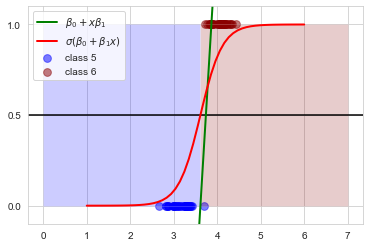

In [117]:
logreg = LogisticRegression(solver='lbfgs')
training_data = df[df['train']==True]
test_data = df[df['train']==False].copy()

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(training_data[['x']], training_data['target'])

print(logreg.intercept_[0])
print(logreg.coef_[0,0])

plot_logistic_model(df[df['train']==True], logreg.intercept_[0], logreg.coef_[0,0])

In [118]:
test_data = df[df['train']==False].copy()
test_data['predicted'] = logreg.predict(test_data[['x']])
test_data['error'] = test_data['predicted']!=test_data['target']
test_data

,x,y,digit,target,train,predicted,error
70,4.217143,3.357143,6,1,False,1,False
71,4.129825,3.270175,6,1,False,1,False
72,4.119454,3.658703,6,1,False,1,False
73,3.862434,3.605820,6,1,False,1,False
74,4.202454,3.245399,6,1,False,1,False
75,3.469091,3.541818,5,0,False,0,False
76,3.254613,3.059041,5,0,False,0,False
77,3.533141,3.521614,5,0,False,0,False
78,3.927954,3.478386,6,1,False,1,False
79,4.379928,3.655914,6,1,False,1,False


Just like our own implementation, the implementation of logistic regression in the `sklearn` module correctly classifies all images in the test data set!

While there is much more to say about topics like how to use logistic regression for non-binary classification, how  it is related to neural networks, or how we can apply regularization to logistic regression, we close this introductory tutorial here, and I must refer you to my MSc course on data science.